# install library

In [1]:
import os

if os.environ.get("KAGGLE_KERNEL_RUN_TYPE") is None:
    ON_KAGGLE = False
else:
    ON_KAGGLE = True
if not ON_KAGGLE:
    import shutil
    from requests import get

    from google.colab import drive, files
    # mount Google Drive
    drive.mount("/content/drive")
else:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

Mounted at /content/drive


In [2]:
if not ON_KAGGLE: 
    !pip uninstall -y kaggle
    !pip install kaggle
    !mkdir /root/.kaggle
    !cp /content/drive/MyDrive/kaggla-za/kaggle.json /root/.kaggle
    !kaggle datasets download -d  kozodoi/timm-pytorch-image-models
    !mkdir -p ../input/timm-pytorch-image-models
    !unzip -n -qq timm-pytorch-image-models.zip -d ../input/timm-pytorch-image-models

Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
     |████████████████████████████████| 58 kB 3.8 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=5f87b2789f6739583c514d0b4bb7346fecc20bfe4b2021b3fb4e14edbfa47b02
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
 63% 9.00M/14.3M [00:00<00:00, 27.7MB/s]
100% 14.3M/14.3M [00:00<00:00, 43.5MB/s]


In [3]:
import sys
sys.path.append("../input/timm-pytorch-image-models/pytorch-image-models-master")

if not ON_KAGGLE:
    !pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

import gc
import math
import os
import pickle
import random
import re
import time
import warnings
from contextlib import contextmanager

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import torch
import torch.nn as nn
import torch.nn.functional as F


#from albumentations.pytorch import ToTensorV2
from scipy.special import softmax
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

import timm
warnings.filterwarnings('ignore')

     |████████████████████████████████| 117 kB 8.1 MB/s 
     |████████████████████████████████| 948 kB 44.7 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=3fde3cbde2bda69620929e829392e2b41dfa391a25277eefbd07ca0d97d359d3
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


# Config


In [4]:
class Config:
    Version = "exp3" # model save時のversion
    #MODEL_NAME = "resnet34" # モデル名
    MODEL_NAME = "resnet50" # モデル名
    #MODEL_NAME = "efficientnet_b0" # モデル名
    #MODEL_NAME = "efficientnet_b7" # モデル名

    if ON_KAGGLE:
        # if MODEL_NAME == 'resnet34':
        #     model_name = '../input/pt-longformer-base' # https://www.kaggle.com/kishalmandal/pt-longformer-base
        # elif MODEL_NAME == 'roberta-base':
        #     model_name = '../input/roberta-base' #https://www.kaggle.com/abhishek/roberta-base
        # elif modeMODEL_NAMEl_savename == 'roberta-large':
        #     model_name = '../input/robertalarge' # https://www.kaggle.com/marshal02/robertalarge
        # elif MODEL_NAME == 'longformer-large':
        #     model_name = '../input/longformerlarge4096' # https://www.kaggle.com/hengzheng/longformerlarge4096 
        #base_dir = '/content/drive/MyDrive/petfinder'
        data_dir = '../input/digit-recognizer/' # = DATA_PATH
        pre_data_dir = './preprocessed/'
        model_dir = '.'
        output_dir = '.'   
    else:
        # customize for my own Google Colab Environment
        # if model_savename == 'longformer':
        #     model_name = 'allenai/longformer-base-4096'
        # elif model_savename == 'roberta-base':
        #     model_name = 'roberta-base'
        base_dir = '/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer'
        data_dir = os.path.join(base_dir, 'data')
        pre_data_dir = os.path.join(base_dir, 'data/preprocessed')
        model_dir = os.path.join(base_dir, f'model/{Version}')
        output_dir = os.path.join(base_dir, f'output/{Version}')    

    is_debug = False
    if MODEL_NAME == 'resnet34':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'roberta-base':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'resnet50':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    seed = 42 # seed値
    fold = 0
    num_workers = 0 #並列実行する数
    batch_size = 64 #バッチサイズ was 64 >100
    epochs =5 #エポック数 10?
    #size = 224 # リサイズした後の画像のサイズ
    #model_lr = 1e-5 # 学習率
    T_max = 10 # 最大イテレーション数 was 10
    min_lr = 1e-6 # 学習率の最小値
    weight_decay = 1e-6 # 学習減衰値
    max_grad_norm = 1000 # 勾配の最大ノルム
    print_freq = 1000 # 学習結果を表示する頻度
    class_num = 10
    N_FOLDS = 5
    device = "cuda" if torch.cuda.is_available() else "cpu" # CPU of GPU


In [5]:
if not ON_KAGGLE:
    if not os.path.exists(Config.model_dir):
        !mkdir $Config.model_dir
    if not os.path.exists(Config.output_dir):
        !mkdir $Config.output_dir

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

# Utils

In [7]:
def init_logger(log_file='train.log'):
    """Output Log."""
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def seed_torch(seed=Config.seed): # was seed=0
    """Fixed seed value."""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # added trueにすると再現性がなくなる


LOGGER = init_logger()
seed_torch(seed=Config.seed)

In [8]:
def asMinutes(s):
    """Convert Seconds to Minutes."""
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    """Accessing and Converting Time Data."""
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

class AverageMeter(object):
    """Computes and stores the average and current value."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Dataset

In [9]:
class TrainDataset(Dataset):
    """Dataset used for training."""
    def __init__(self, df, transform=None):
        self.df = df
        self.labels = df['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = self.df.loc[idx, "pixel0": "pixel783"].values.astype(np.uint8).reshape(28, 28) # csv to image
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) # GRAY to RGB

        if self.transform:
            augmented = self.transform(image=image) # augmentation
            image = augmented['image']

        label = self.labels[idx] # 正解ラベル
        return image, label

In [10]:
class TestDataset(Dataset):
    """Dataset used for inference."""
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = self.df.loc[idx, "pixel0": "pixel783"].values.astype(np.uint8).reshape(28, 28)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image

# Data Augmentation

In [11]:
def get_transforms(*, data, size, norms):

    if data == 'train':
        return A.Compose([
            A.Resize(Config.size, Config.size), # リサイズ
            A.Normalize(mean=[norms[0], norms[0], norms[0]], std=[norms[1], norms[1], norms[1]], max_pixel_value=255.0, p=1.0), # 正規化
            ToTensorV2(), # Tensor型に変換
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(Config.size, Config.size),
            A.Normalize(mean=[norms[0], norms[0], norms[0]], std=[norms[1], norms[1], norms[1]], max_pixel_value=255.0, p=1.0),
            ToTensorV2(),
        ])

# Model

In [12]:
# use timm model no pretrained
class BaseModel(nn.Module):
    def __init__(
        self, model_name=Config.MODEL_NAME, n_class=10, pretrained=False
    ):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained) # model load(pretrained=False: 事前学習なし)
        n_features = self.model.fc.in_features
        self.model.classifier = nn.Linear(n_features, n_class) # 出力層の次元をクラス数に変更

    def forward(self, x):
        output = self.model(x)
        return output

# train & valid function

In [13]:
def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    model.train() # 学習モード
    start = end = time.time()
    global_step = 0

    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(Config.device) # 画像をcpuからgpuヘ
        labels = labels.to(Config.device) # 正解ラベルをcpuからgpuヘ
        batch_size = labels.size(0) 
        y_preds = model(images) # 予測ラベル
        loss = criterion(y_preds, labels) # lossの計算

        losses.update(loss.item(), batch_size) 
        loss.backward() # パラメータの勾配を計算
        
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), Config.max_grad_norm)
        optimizer.step() # モデル更新
        optimizer.zero_grad() # 勾配の初期化
        global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % Config.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   ))

        del y_preds, images, labels, batch_size
    del batch_time, data_time, model
    gc.collect()
    torch.cuda.empty_cache()
    
    return losses.avg

In [14]:
def valid_fn(valid_loader, model, criterion):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(Config.device)
        labels = labels.to(Config.device)
        batch_size = labels.size(0)
        with torch.no_grad():
        #with torch.inference_mode(): Pytorch: ^1.9
            y_preds = model(images)
            loss = criterion(y_preds, labels)
            losses.update(loss.item(), batch_size)
            
            preds.append(y_preds.softmax(1).to("cpu").numpy().argmax(1))
            del loss
            batch_time.update(time.time() - end)
            end = time.time()
            if step % Config.print_freq == 0 or step == (len(valid_loader)-1):
                print('EVAL: [{0}/{1}] '
                    'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                    'Elapsed {remain:s} '
                    'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                    .format(
                    step, len(valid_loader), batch_time=batch_time,
                    data_time=data_time, loss=losses,
                    remain=timeSince(start, float(step+1)/len(valid_loader)),
                    ))
        del y_preds, images, labels, batch_size
    del batch_time, data_time, model
    gc.collect()
    torch.cuda.empty_cache()

    preds = np.concatenate(preds)

    return losses.avg, preds

# Dataの確認

In [15]:
#data_dir = "../input/digit-recognizer" # ディレクトリパス = data_dir
if ON_KAGGLE:
    train = pd.read_csv(Config.data_dir + "/train.csv") # csvの読み込み
else:
    train = pd.read_csv(f'{Config.data_dir}/train/train.csv')
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
import plotly.express as px

target = train.label.value_counts()
# class_num = len(target)

fig = px.pie(target,
             values='label',
             names=target.index,
             hole=.4, 
             width=500, height=500)
fig.update_traces(textinfo='value+label', pull=0.01)
fig.show()

In [17]:
fig = px.bar(target.sort_index().index, target.sort_index(), width=1000, height=400)
fig.show()

# 前処理

### ホールドアウト

In [18]:
# f0, f1 = train_test_split(train, test_size=0.2) # 学習用と評価用に分ける
# train["folds"] = -1
# train.loc[f0.index, "folds"] = 1
# train.loc[f1.index, "folds"] = 0

## StratifiedKFold


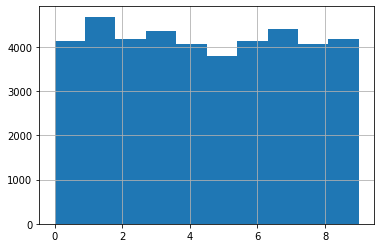

In [19]:
train['bins'] = pd.cut(train['label'], bins=Config.class_num, labels=False)
train['bins'].hist()

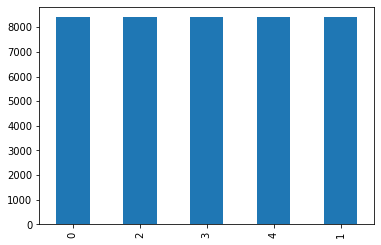

In [20]:
from sklearn.model_selection import StratifiedKFold

train['fold'] = -1

strat_kfold = StratifiedKFold(n_splits=Config.N_FOLDS, random_state=Config.seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train.index, train['bins'])):
    train.iloc[train_index, -1] = i
    
train['fold'] = train['fold'].astype('int')

train.fold.value_counts().plot.bar()

In [21]:
train[train['fold']==0].head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,bins,fold
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0
9,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0


In [22]:
train[train['fold']==0]['bins'].value_counts()

1    937
7    880
3    870
9    838
2    835
0    827
6    827
4    814
8    813
5    759
Name: bins, dtype: int64

In [23]:
train[train['fold']==1]['bins'].value_counts()

1    937
7    880
3    870
9    837
2    836
6    827
0    826
4    815
8    813
5    759
Name: bins, dtype: int64

#### 平均と標準偏差を計算

In [24]:
images = train.loc[:, "pixel0": "pixel783"].values.astype(np.uint8).reshape(-1, 28, 28)
norms = (np.mean(images[train.fold!=0] / 255), np.std(images[train.fold!=0] / 255)) # 平均と標準偏差を計算
print("平均と標準偏差: ", norms)

平均と標準偏差:  (0.13097058957511565, 0.30850036897768457)


#### 画像サイズの確認と数例を表示

height:  28
weight:  28


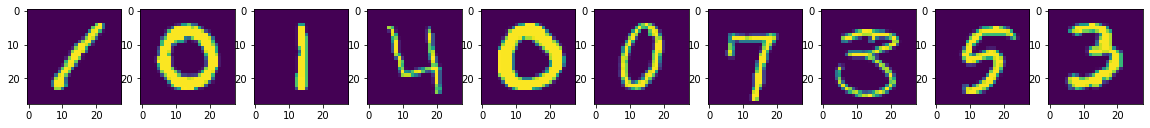

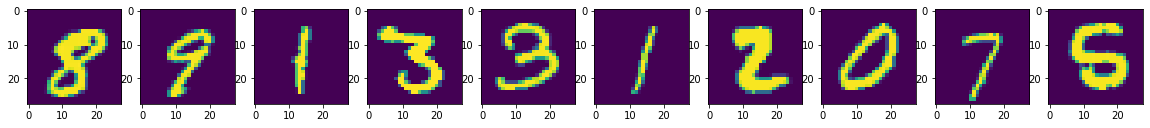

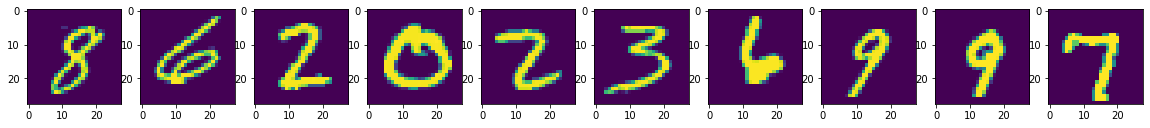

In [25]:
print("height: ", images.shape[1])
print("weight: ", images.shape[2])

for n in range(3):
    fig, axes = plt.subplots(1, 10, figsize=(20, 30))
    [axes[i].imshow(images[idx]) for i, idx in enumerate(range(n*10, (n+1)*10))]

    plt.show()

# 学習の際必要になる知識

## 評価指標(Accuracy), Confusion matrix
#### 詳細については、来週説明

## ハイパラメータの用語簡易説明など

> #### * 学習率 : 学習一回当たりの更新量のようなものです。 今回のデフォルトは1e-5です。
> #### * スケジューラー : epoch数に応じて、学習率を変化させるものです。 今回のデフォルトはCosineAnnealingLRです。
> #### * 損失関数: 正解ラベルと予測ラベルの誤差の大きさを計算する関数。 
> #### * 最適化関数: 効率よく損失を減らすための関数。 
> #### * timm : 画像のコンペでpytorchを使う場合にほぼ確実に使用するライブラリですので、見ておきましょう。[github](https://github.com/rwightman/pytorch-image-models)

# 軽めのモデル作成

### モデルの読み込み

In [26]:
model = BaseModel(Config.MODEL_NAME, Config.class_num)
model

BaseModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

### 最適化関数

In [27]:
# Adam は勾配を移動平均と学習率の調整からなります (MomentumとRMSProp)
optimizer = Adam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)

### スケジューラ

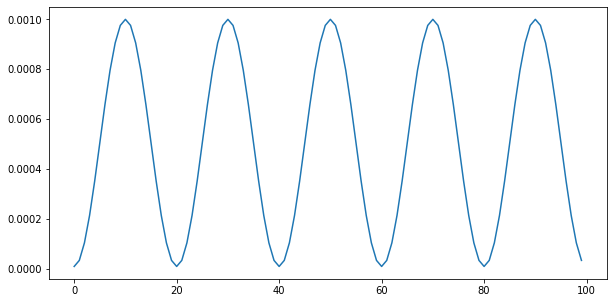

In [28]:
scheduler = CosineAnnealingLR(optimizer, T_max=Config.T_max, eta_min=0.001)

log_s = []
for epoch in range(0, 100):
    log_s.append(scheduler.get_last_lr()[0])
    scheduler.step()

plt.figure(figsize=(10, 5))
plt.plot(np.arange(100), log_s)
plt.show()

# 学習

In [29]:
def train_loop(train, fold, class_num=Config.class_num, norms=(0.5, 0.5)):
    
    print('='*20 +'Fold '+ f'{fold}' + '='*20)
    train_index = train[train['fold'] != fold].index # 学習用のindex
    valid_index = train[train['fold'] == fold].index # 評価用のindex

    train_dataset = TrainDataset(train.loc[train_index].reset_index(drop=True), 
                                 transform=get_transforms(data='train', size=Config.size, norms=norms)) # 学習用のdatasetを作成
    valid_dataset = TrainDataset(train.loc[valid_index].reset_index(drop=True), 
                                 transform=get_transforms(data='valid', size=Config.size, norms=norms)) # 評価用のdatasetを作成

    train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, 
                              num_workers=Config.num_workers, pin_memory=True, drop_last=True)# 学習用のdatasetsのbatchを作成
    valid_loader = DataLoader(valid_dataset, batch_size=Config.batch_size, shuffle=False, 
                              num_workers=Config.num_workers, pin_memory=True, drop_last=False) # 評価用のdatasetsのbatchを作成
    
    
    model = BaseModel(Config.MODEL_NAME, class_num).to(Config.device)

    optimizer = Adam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)
    scheduler = CosineAnnealingLR(optimizer, T_max=Config.T_max, eta_min=Config.min_lr, last_epoch=-1)

    criterion = nn.CrossEntropyLoss() # loss function

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(Config.epochs):
        start_time = time.time()
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler) # 学習
        avg_val_loss, predict = valid_fn(valid_loader, model, criterion) # 評価用の推論
        valid_labels = train.loc[valid_index, "label"].values # 予測ラベル
        
        scheduler.step() 
        score = accuracy_score(valid_labels, predict) # 適合率を計算
        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            model_filename = f'{Config.model_dir}/{Config.MODEL_NAME}_fold{fold}_best_{Config.Version}.pth'
            torch.save(model.state_dict(), model_filename) # モデルの保存
            #torch.save(model.state_dict(), "./" + f'{Config.MODEL_NAME}_fold{fold}_best_{Config.Version}.pth') # モデルの保存
            print(f'{model_filename} saved')

            valid_folds_predict = predict
            
        del avg_loss, avg_val_loss, valid_labels, predict, score
        gc.collect()
        torch.cuda.empty_cache()

    return valid_folds_predict

In [ ]:
preds = [train_loop(train, fold=fold, class_num=Config.class_num, norms=norms) for fold in range(Config.N_FOLDS) ]

====================Fold 0====================
Epoch: [1][0/525] Data 0.174 (0.174) Elapsed 0m 1s (remain 9m 27s) Loss: 6.9503(6.9503) 
Epoch: [1][524/525] Data 0.118 (0.111) Elapsed 6m 49s (remain 0m 0s) Loss: 2.0667(3.5147) 
EVAL: [0/132] Data 0.120 (0.120) Elapsed 0m 0s (remain 0m 40s) Loss: 2.1218(2.1218) 


Epoch 1 - avg_train_loss: 3.5147  avg_val_loss: 2.0751  time: 449s
Epoch 1 - Accuracy: 0.36345238095238097
Epoch 1 - Save Best Score: 0.3635 Model


EVAL: [131/132] Data 0.027 (0.108) Elapsed 0m 38s (remain 0m 0s) Loss: 2.0786(2.0751) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold0_best_exp3.pth saved
Epoch: [2][0/525] Data 0.109 (0.109) Elapsed 0m 0s (remain 6m 57s) Loss: 2.0718(2.0718) 
Epoch: [2][524/525] Data 0.098 (0.106) Elapsed 6m 57s (remain 0m 0s) Loss: 1.5028(1.8314) 
EVAL: [0/132] Data 0.110 (0.110) Elapsed 0m 0s (remain 0m 38s) Loss: 1.7154(1.7154) 


Epoch 2 - avg_train_loss: 1.8314  avg_val_loss: 1.6396  time: 456s
Epoch 2 - Accuracy: 0.5584523809523809
Epoch 2 - Save Best Score: 0.5585 Model


EVAL: [131/132] Data 0.025 (0.101) Elapsed 0m 37s (remain 0m 0s) Loss: 1.6244(1.6396) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold0_best_exp3.pth saved
Epoch: [3][0/525] Data 0.120 (0.120) Elapsed 0m 0s (remain 7m 2s) Loss: 1.6275(1.6275) 
Epoch: [3][524/525] Data 0.100 (0.110) Elapsed 7m 0s (remain 0m 0s) Loss: 1.1251(1.3877) 
EVAL: [0/132] Data 0.104 (0.104) Elapsed 0m 0s (remain 0m 38s) Loss: 1.4415(1.4415) 


Epoch 3 - avg_train_loss: 1.3877  avg_val_loss: 1.2717  time: 459s
Epoch 3 - Accuracy: 0.6017857142857143
Epoch 3 - Save Best Score: 0.6018 Model


EVAL: [131/132] Data 0.025 (0.104) Elapsed 0m 38s (remain 0m 0s) Loss: 1.3543(1.2717) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold0_best_exp3.pth saved
Epoch: [4][0/525] Data 0.110 (0.110) Elapsed 0m 0s (remain 7m 4s) Loss: 1.1366(1.1366) 


# 推論

In [ ]:
def inference(test, class_num=Config.class_num, n=0, norms=(0.5, 0.5)):
    model = BaseModel(Config.MODEL_NAME, class_num, pretrained=False)

    model.load_state_dict(torch.load(f'{Config.model_dir}/{Config.MODEL_NAME}_fold{n}_best_{Config.Version}.pth')) # 重みの読み込み
    model.to(Config.device)
    
    test_dataset = TestDataset(test, transform=get_transforms(data='valid', size=Config.size, norms=norms))
    test_loader = DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=False, num_workers=Config.num_workers)
    
    all_predicts = []
    model.eval() # 推論モード
    with torch.no_grad(): # 勾配の計算をしない
        for i, (images) in tqdm(enumerate(test_loader), total=len(test_loader)):
            images = images.to(Config.device)
            y_preds = model(images)
            predicts = y_preds.softmax(1).to("cpu").numpy().argmax(1)
            all_predicts.append(predicts)
    
    predicts = np.concatenate(all_predicts)
        
    return predicts

In [ ]:
#MODEL_PATH = "./" # 自身の作成したモデルへのPATH

if ON_KAGGLE:
    test = pd.read_csv(Config.data_dir + "/test.csv")
    submit = pd.read_csv(Config.data_dir + "/sample_submission.csv")
else:
    test = pd.read_csv(f'{Config.data_dir}/test/test.csv')
    submit = pd.read_csv(f'{Config.data_dir}/sample_submission.csv')

In [ ]:
predicts = [inference(test, class_num=Config.class_num, n=fold, norms=norms) for fold in range(Config.N_FOLDS)]
predicts_em = np.argmax(np.sum(predicts, axis=0), axis=1)

In [ ]:
# predicts_2 = [inference(test, "resnet50", n=fold) for fold in range(5)]
# predicts_2_em = np.argmax(np.sum(predicts, axis=0), axis=1)

# predicts_em = np.mean(predicts, axis=0)
# predicts_2_em = np.mean(predicts_2, axis=0)

# predicts_final = np.argmax(predicts_em * 0.7 + predicts_2_em * 0.3, axis=1)


# 後処理

In [ ]:
submit["Label"] = predicts # 提出用csvに書き込み
submit.to_csv('submission.csv', index=False) # csvを書き出す

In [ ]:
submit

In [ ]:
submit['Label'].unique()

In [ ]:
submit.to_csv(f'{Config.output_dir}/{Config.Version}.csv', index=False)